# Capstone 3: Making Predictions on Depletion of Five Natural Resources

## Production and Consumption: Synthetic Control

In [293]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import random
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from IPython.display import clear_output
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve
from sklearn.linear_model import Lasso

In [2]:
!pip install pycausalimpact

In [294]:
from statsmodels.tsa.arima_process import ArmaProcess
from causalimpact import CausalImpact

### 1. Oil

In [295]:
# Load data
path1 = r'C:\Users\yuvem\ds_oil_consumption_melt.xlsx'
xls = pd.ExcelFile(path1)
ds = pd.read_excel(xls)
ds

,Country,Year,Barrels_daily
0,Canada,1965,1108.116301
1,Mexico,1965,315.871088
2,US,1965,11512.436000
3,NaN,1965,NaN
4,Argentina,1965,455.904822
...,...,...,...
5595,Taiwan,2020,973.107164
5596,Thailand,2020,1271.199472
5597,Vietnam,2020,490.671699
5598,Other Asia Pacific,2020,471.636775


### 1.a Data Cleaning

In [296]:
# Check total NaN values
ds.isna().sum()

Country          392
Year               0
Barrels_daily    729
dtype: int64

In [297]:
# Drop NaN values
ds.dropna()
# Eliminate NaN from 'Country' column
ds_clean = ds[ds["Country"].notna()]
# Replace missing values in 'Barrels_daily' with mean
ds_clean["Barrels_daily"] = ds_clean["Barrels_daily"].fillna(ds_clean.Barrels_daily.mean())

In [298]:
ds.Country.unique()

array(['Canada', 'Mexico', 'US', nan, 'Argentina', 'Brazil', 'Chile',
       'Colombia', 'Ecuador', 'Peru', 'Trinidad & Tobago', 'Venezuela',
       'Central America', 'Other Caribbean', 'Other South America',
       'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus',
       'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France',
       'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy',
       'Latvia', 'Lithuania', 'Luxembourg', 'Netherlands',
       'North Macedonia', 'Norway', 'Poland', 'Portugal', 'Romania',
       'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Turkey',
       'Ukraine', 'United Kingdom', 'Other Europe ', 'Total Europe ',
       'Azerbaijan', 'Belarus', 'Kazakhstan', 'Russian Federation',
       'Turkmenistan', 'USSR', 'Uzbekistan', 'Other CIS', 'Iran', 'Iraq',
       'Israel', 'Kuwait', 'Oman', 'Qatar', 'Saudi Arabia',
       'United Arab Emirates', 'Other Middle East', 'Algeria', 'Egypt',
       'Morocco', 'South Africa', 'Eastern 

In [299]:
ds.dtypes

Country           object
Year               int64
Barrels_daily    float64
dtype: object

In [300]:
ds_clean.isna().sum()

Country          0
Year             0
Barrels_daily    0
dtype: int64

In [301]:
# Convert Year to datetime
ds_clean['Year'] = pd.to_datetime(ds_clean.Year, format='%Y')

### 1.b Venezuela

In [302]:
# Find index for Venezuela
i = ds_clean[((ds_clean.Country == 'Venezuela'))].index
i

Int64Index([  11,  111,  211,  311,  411,  511,  611,  711,  811,  911, 1011,
            1111, 1211, 1311, 1411, 1511, 1611, 1711, 1811, 1911, 2011, 2111,
            2211, 2311, 2411, 2511, 2611, 2711, 2811, 2911, 3011, 3111, 3211,
            3311, 3411, 3511, 3611, 3711, 3811, 3911, 4011, 4111, 4211, 4311,
            4411, 4511, 4611, 4711, 4811, 4911, 5011, 5111, 5211, 5311, 5411,
            5511],
           dtype='int64')

In [303]:
# Create separate df for without Venezuela
other_countries = ds_clean.drop(i)
# Transform
other_countries = other_countries.set_index('Year').T
othercountries_subset = other_countries.drop('Country')

# Separate df for only Venezuela
venezuela = ds_clean[((ds_clean.Country == 'Venezuela'))]
# Transform
venezuela = venezuela.set_index('Year').T
venezuela_subset = venezuela.drop('Country')

In [304]:
venezuela_subset

Year,1965-01-01,1966-01-01,1967-01-01,1968-01-01,1969-01-01,1970-01-01,1971-01-01,1972-01-01,1973-01-01,1974-01-01,...,2011-01-01,2012-01-01,2013-01-01,2014-01-01,2015-01-01,2016-01-01,2017-01-01,2018-01-01,2019-01-01,2020-01-01
Barrels_daily,183.879953,181.469395,185.728871,201.42559,200.370616,209.874364,212.341753,230.821601,257.25874,259.424603,...,720.639562,784.801612,834.859877,746.403925,696.901659,537.383707,492.826716,409.781167,295.88749,241.64205


In [305]:
# Combine the two datasets
ds_combine = othercountries_subset.append(venezuela_subset, ignore_index=True)
ds_combine

Year,1965-01-01,1965-01-01,1965-01-01,1965-01-01,1965-01-01,1965-01-01,1965-01-01,1965-01-01,1965-01-01,1965-01-01,...,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01
0,1108.116301,315.871088,11512.436,455.904822,305.673808,70.51694,81.432291,13.394795,74.43827,35.17133,...,147.975594,437.336774,377.538233,1332.368002,2560.202186,103.544796,973.107164,1271.199472,490.671699,471.636775
1,183.879953,183.879953,183.879953,183.879953,183.879953,183.879953,183.879953,183.879953,183.879953,183.879953,...,241.64205,241.64205,241.64205,241.64205,241.64205,241.64205,241.64205,241.64205,241.64205,241.64205


In [306]:
# Transform
ds_combine_transform = ds_combine.T

In [307]:
ds_combine_transform[1]

Year
1965-01-01    183.879953
1965-01-01    183.879953
1965-01-01    183.879953
1965-01-01    183.879953
1965-01-01    183.879953
                 ...    
2020-01-01     241.64205
2020-01-01     241.64205
2020-01-01     241.64205
2020-01-01     241.64205
2020-01-01     241.64205
Name: 1, Length: 5152, dtype: object

In [308]:
# Remove duplicates 
ds_combine_transform = ds_combine_transform[~ds_combine_transform.index.duplicated(keep='first')]

In [309]:
ds_combine_transform

,0,1
Year,,
1965-01-01,1108.116301,183.879953
1966-01-01,1167.468795,181.469395
1967-01-01,1245.557068,185.728871
1968-01-01,1322.15735,201.42559
1969-01-01,1380.190329,200.370616
1970-01-01,1471.579753,209.874364
1971-01-01,1512.128247,212.341753
1972-01-01,1588.909235,230.821601
1973-01-01,1754.885644,257.25874


### 1.b Saudi Arabia

In [310]:
# Find index for Saudi Arabia
i2 = ds_clean[((ds_clean.Country == 'Saudi Arabia'))].index
i2

Int64Index([  67,  167,  267,  367,  467,  567,  667,  767,  867,  967, 1067,
            1167, 1267, 1367, 1467, 1567, 1667, 1767, 1867, 1967, 2067, 2167,
            2267, 2367, 2467, 2567, 2667, 2767, 2867, 2967, 3067, 3167, 3267,
            3367, 3467, 3567, 3667, 3767, 3867, 3967, 4067, 4167, 4267, 4367,
            4467, 4567, 4667, 4767, 4867, 4967, 5067, 5167, 5267, 5367, 5467,
            5567],
           dtype='int64')

In [311]:
# Create separate df for without Saudi Arabia
other_countries2 = ds_clean.drop(i2)
# Transform
other_countries2 = other_countries2.set_index('Year').T
othercountries_subset2 = other_countries2.drop('Country')

# Separate df for only Saudi Arabia
saudi = ds_clean[((ds_clean.Country == 'Saudi Arabia'))]
# Transform
saudi = saudi.set_index('Year').T
saudi_subset = saudi.drop('Country')

In [312]:
# Check
saudi_subset

Year,1965-01-01,1966-01-01,1967-01-01,1968-01-01,1969-01-01,1970-01-01,1971-01-01,1972-01-01,1973-01-01,1974-01-01,...,2011-01-01,2012-01-01,2013-01-01,2014-01-01,2015-01-01,2016-01-01,2017-01-01,2018-01-01,2019-01-01,2020-01-01
Barrels_daily,389.574466,392.916027,396.259562,398.552514,403.065123,434.741397,441.319344,470.255456,500.584796,525.607812,...,3285.316285,3451.20718,3444.033052,3759.831738,3878.700539,3865.354756,3798.747608,3617.030111,3634.669328,3543.806411


In [313]:
# Combine the two datasets
ds_combine2 = othercountries_subset2.append(saudi_subset, ignore_index=True)
ds_combine2

Year,1965-01-01,1965-01-01,1965-01-01,1965-01-01,1965-01-01,1965-01-01,1965-01-01,1965-01-01,1965-01-01,1965-01-01,...,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01
0,1108.116301,315.871088,11512.436,455.904822,305.673808,70.51694,81.432291,13.394795,74.43827,35.17133,...,147.975594,437.336774,377.538233,1332.368002,2560.202186,103.544796,973.107164,1271.199472,490.671699,471.636775
1,389.574466,389.574466,389.574466,389.574466,389.574466,389.574466,389.574466,389.574466,389.574466,389.574466,...,3543.806411,3543.806411,3543.806411,3543.806411,3543.806411,3543.806411,3543.806411,3543.806411,3543.806411,3543.806411


In [314]:
# Transform
ds_combine_transform2 = ds_combine2.T

In [315]:
# Remove duplicates 
ds_combine_transform2 = ds_combine_transform2[~ds_combine_transform2.index.duplicated(keep='first')]

In [316]:
ds_combine_transform2

,0,1
Year,,
1965-01-01,1108.116301,389.574466
1966-01-01,1167.468795,392.916027
1967-01-01,1245.557068,396.259562
1968-01-01,1322.15735,398.552514
1969-01-01,1380.190329,403.065123
1970-01-01,1471.579753,434.741397
1971-01-01,1512.128247,441.319344
1972-01-01,1588.909235,470.255456
1973-01-01,1754.885644,500.584796


### 1.c Canada

In [317]:
# Find index for Canada
i3 = ds_clean[((ds_clean.Country == 'Canada'))].index
i3

Int64Index([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
            1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100,
            2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200,
            3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300,
            4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400,
            5500],
           dtype='int64')

In [318]:
# Create separate df for without Canada
other_countries3 = ds_clean.drop(i3)
# Transform
other_countries3 = other_countries3.set_index('Year').T
othercountries_subset3 = other_countries3.drop('Country')

# Separate df for only Canada
canada = ds_clean[((ds_clean.Country == 'Canada'))]
# Transform
canada = canada.set_index('Year').T
canada_subset = canada.drop('Country')

In [319]:
# Again, check
canada_subset

Year,1965-01-01,1966-01-01,1967-01-01,1968-01-01,1969-01-01,1970-01-01,1971-01-01,1972-01-01,1973-01-01,1974-01-01,...,2011-01-01,2012-01-01,2013-01-01,2014-01-01,2015-01-01,2016-01-01,2017-01-01,2018-01-01,2019-01-01,2020-01-01
Barrels_daily,1108.116301,1167.468795,1245.557068,1322.15735,1380.190329,1471.579753,1512.128247,1588.909235,1754.885644,1787.261868,...,2399.914318,2423.735391,2419.498225,2418.769294,2442.003685,2452.037349,2422.998806,2500.80635,2536.766731,2282.478848


In [320]:
# Combine the two datasets
ds_combine3 = othercountries_subset3.append(canada_subset, ignore_index=True)
ds_combine3

Year,1965-01-01,1965-01-01,1965-01-01,1965-01-01,1965-01-01,1965-01-01,1965-01-01,1965-01-01,1965-01-01,1965-01-01,...,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01
0,315.871088,11512.436,455.904822,305.673808,70.51694,81.432291,13.394795,74.43827,35.17133,183.879953,...,147.975594,437.336774,377.538233,1332.368002,2560.202186,103.544796,973.107164,1271.199472,490.671699,471.636775
1,1108.116301,1108.116301,1108.116301,1108.116301,1108.116301,1108.116301,1108.116301,1108.116301,1108.116301,1108.116301,...,2282.478848,2282.478848,2282.478848,2282.478848,2282.478848,2282.478848,2282.478848,2282.478848,2282.478848,2282.478848


In [321]:
# Transform
ds_combine_transform3 = ds_combine3.T

In [322]:
# Remove duplicates 
ds_combine_transform3 = ds_combine_transform3[~ds_combine_transform3.index.duplicated(keep='first')]

In [323]:
ds_combine_transform3

,0,1
Year,,
1965-01-01,315.871088,1108.116301
1966-01-01,333.048484,1167.468795
1967-01-01,357.305957,1245.557068
1968-01-01,386.144762,1322.15735
1969-01-01,410.021906,1380.190329
1970-01-01,440.735987,1471.579753
1971-01-01,467.284852,1512.128247
1972-01-01,523.353166,1588.909235
1973-01-01,564.177805,1754.885644


In [324]:
venez_copy_ds = ds_combine_transform.copy()
saudi_copy_ds = ds_combine_transform2.copy()
canada_copy_ds = ds_combine_transform3.copy()

In [325]:
venez_copy_df = venez_copy_ds.reset_index()
saudi_copy_df = saudi_copy_ds.reset_index()
canada_copy_df = canada_copy_ds.reset_index()

In [326]:
venez_copy_df.to_csv('venez_copy_df.csv', index=False, header=True)
saudi_copy_df.to_csv('saudi_copy_df.csv', index=False, header=True)
canada_copy_df.to_csv('canada_copy_df.csv', index=False, header=True)

## 2 Causal Impact

### 2.a Venezuela

In [327]:
# Create pre and post periods
pre_period = ['1965-01-01','2009-01-01'] 
post_period = ['2010-01-01','2020-01-01']

In [328]:
pre_period

['1965-01-01', '2009-01-01']

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    2425.87            26684.62
Prediction (s.d.)         2162.45 (51.49)    23786.96 (566.35)
95% CI                    [2060.57, 2262.39] [22666.26, 24886.31]

Absolute effect (s.d.)    263.42 (51.49)     2897.66 (566.35)
95% CI                    [163.48, 365.31]   [1798.32, 4018.36]

Relative effect (s.d.)    12.18% (2.38%)     12.18% (2.38%)
95% CI                    [7.56%, 16.89%]    [7.56%, 16.89%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 2425.87. By contrast, in the absence of an
intervention, we would have expected an average response of 2162.45.
The 95% interval of this counterfactual prediction is [2060.57, 2262.39].
Subtracting this

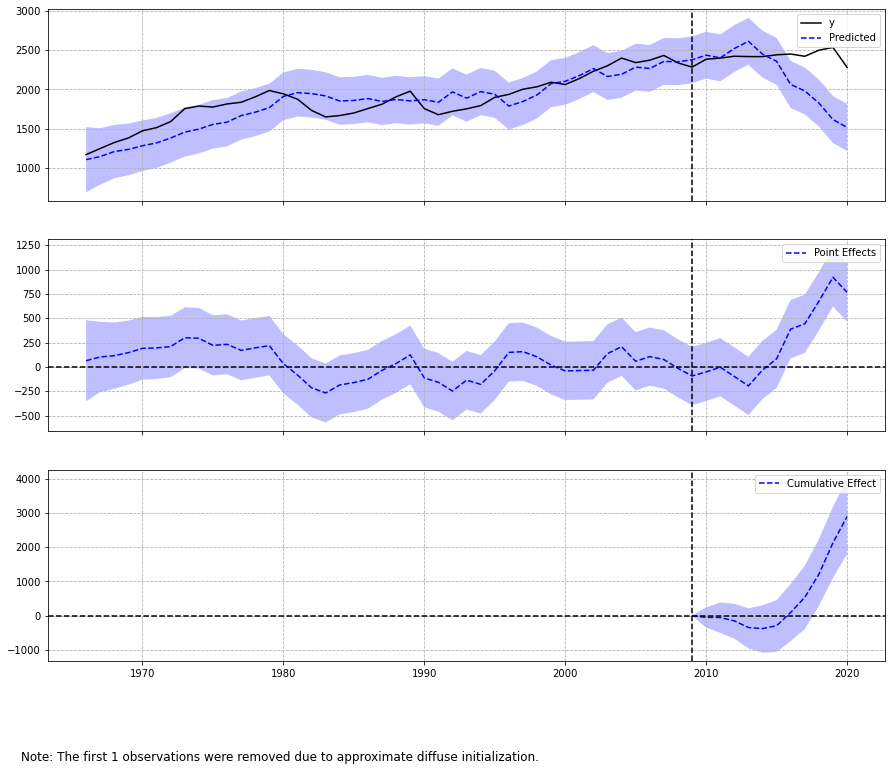

In [329]:
ci = CausalImpact(ds_combine_transform.astype(float), pre_period, post_period)
print(ci.summary())
print(ci.summary(output='report'))
ci.plot()

### 2.b Saudi Arabia

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    2425.87            26684.62
Prediction (s.d.)         2871.68 (57.42)    31588.51 (631.6)
95% CI                    [2763.94, 2989.01] [30403.34, 32879.15]

Absolute effect (s.d.)    -445.81 (57.42)    -4903.88 (631.6)
95% CI                    [-563.14, -338.07] [-6194.53, -3718.72]

Relative effect (s.d.)    -15.52% (2.0%)     -15.52% (2.0%)
95% CI                    [-19.61%, -11.77%] [-19.61%, -11.77%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 2425.87. By contrast, in the absence of an
intervention, we would have expected an average response of 2871.68.
The 95% interval of this counterfactual prediction is [2763.94, 2989.01].
Subtracting 

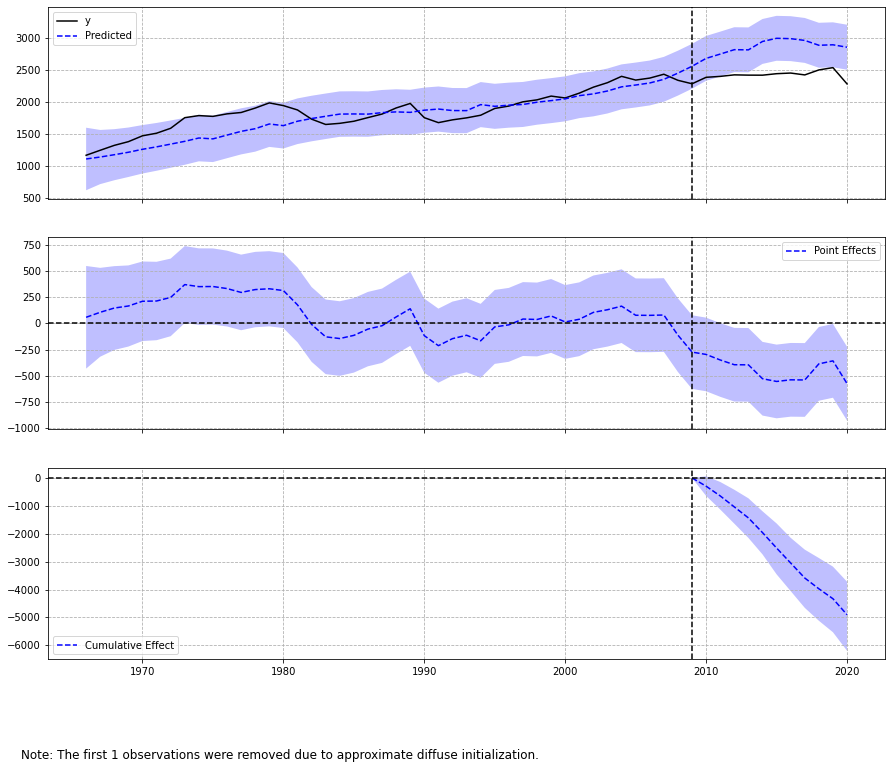

In [330]:
ci2 = CausalImpact(ds_combine_transform2.astype(float), pre_period, post_period)
print(ci2.summary())
print(ci2.summary(output='report'))
ci2.plot()

### 2.c Canada

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    1890.99            20800.88
Prediction (s.d.)         2174.61 (116.7)    23920.74 (1283.66)
95% CI                    [1941.24, 2398.68] [21353.6, 26385.47]

Absolute effect (s.d.)    -283.62 (116.7)    -3119.86 (1283.66)
95% CI                    [-507.69, -50.25]  [-5584.59, -552.73]

Relative effect (s.d.)    -13.04% (5.37%)    -13.04% (5.37%)
95% CI                    [-23.35%, -2.31%]  [-23.35%, -2.31%]

Posterior tail-area probability p: 0.01
Posterior prob. of a causal effect: 98.6%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 1890.99. By contrast, in the absence of an
intervention, we would have expected an average response of 2174.61.
The 95% interval of this counterfactual prediction is [1941.24, 2398.68].
Subtractin

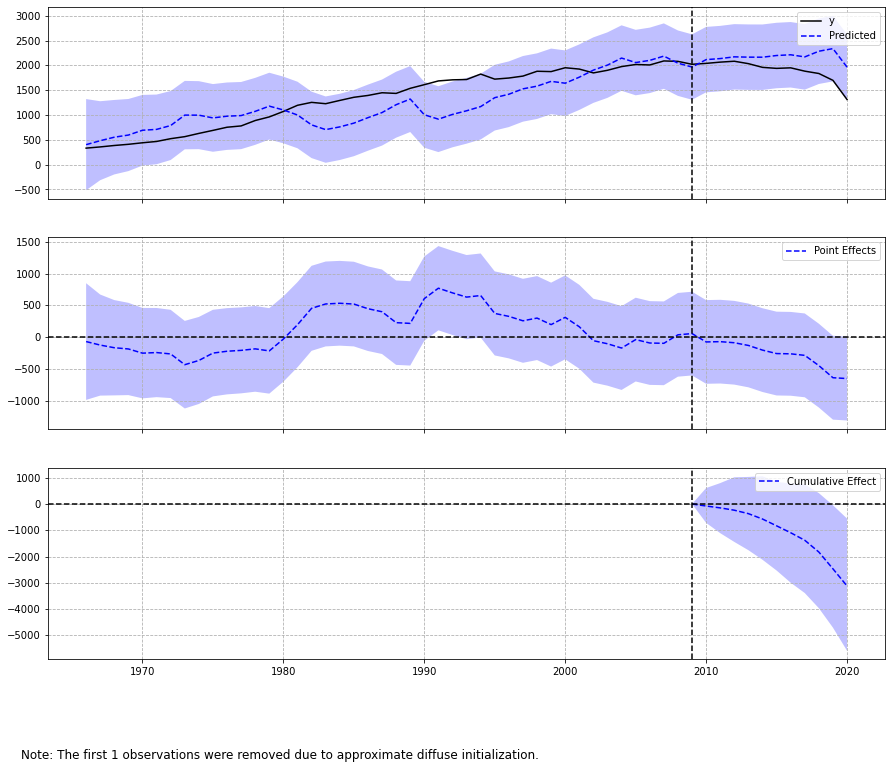

In [331]:
ci3 = CausalImpact(ds_combine_transform3.astype(float), pre_period, post_period)
print(ci3.summary())
print(ci3.summary(output='report'))
ci3.plot()

## 3 Lasso Regression

In [332]:
ds_pivot = ds_clean.pivot_table(index=['Country', 'Year'], values='Barrels_daily')
ds_pivot

Barrels_daily
Country        Year                     
Algeria        1965-01-01      26.716192
               1966-01-01      35.353233
               1967-01-01      33.285973
               1968-01-01      35.374426
               1969-01-01      37.714329
...                                  ...
Western Africa 2016-01-01     633.833068
               2017-01-01     696.812004
               2018-01-01     808.008446
               2019-01-01     816.357377
               2020-01-01     726.432937

[5208 rows x 1 columns]

In [333]:
ds_pivot = ds.pivot_table(index='Year', columns='Country', values='Barrels_daily')

In [334]:
ds_pivot.isnull().sum()

Country
Algeria            0
Argentina          0
Australia          0
Austria            0
Azerbaijan        20
                  ..
United Kingdom     0
Uzbekistan        20
Venezuela          0
Vietnam            0
Western Africa     0
Length: 93, dtype: int64

In [335]:
null_columns = ds_pivot[ds_pivot.columns[ds_pivot.isna().any()]]
null_columns.columns

Index(['Azerbaijan', 'Bangladesh', 'Belarus', 'Croatia', 'Estonia',
       'Kazakhstan', 'Latvia', 'Lithuania', 'North Macedonia', 'Other CIS',
       'Russian Federation', 'Slovenia', 'Turkmenistan', 'USSR', 'Ukraine',
       'Uzbekistan'],
      dtype='object', name='Country')

In [336]:
ds_pivot = ds_pivot.drop(columns='Azerbaijan')
ds_pivot = ds_pivot.drop(columns='Bangladesh')
ds_pivot = ds_pivot.drop(columns='Belarus')
ds_pivot = ds_pivot.drop(columns='Croatia')
ds_pivot = ds_pivot.drop(columns='Estonia')
ds_pivot = ds_pivot.drop(columns='Kazakhstan')
ds_pivot = ds_pivot.drop(columns='Latvia')
ds_pivot = ds_pivot.drop(columns='Lithuania')
ds_pivot = ds_pivot.drop(columns='North Macedonia')
ds_pivot = ds_pivot.drop(columns='Other CIS')
ds_pivot = ds_pivot.drop(columns='Russian Federation')
ds_pivot = ds_pivot.drop(columns='Slovenia')
ds_pivot = ds_pivot.drop(columns='Turkmenistan')
ds_pivot = ds_pivot.drop(columns='USSR')
ds_pivot = ds_pivot.drop(columns='Ukraine')
ds_pivot = ds_pivot.drop(columns='Uzbekistan')

In [337]:
ds_pivot.dropna(axis=1, how='all')

Country,Algeria,Argentina,Australia,Austria,Belgium,Brazil,Bulgaria,Canada,Central America,Chile,...,Thailand,Total Europe,Trinidad & Tobago,Turkey,US,United Arab Emirates,United Kingdom,Venezuela,Vietnam,Western Africa
Year,,,,,,,,,,,,,,,,,,,,,
1965,26.716192,455.904822,343.871534,106.652849,312.112712,305.673808,71.220959,1108.116301,78.491296,70.516940,...,47.561397,8219.067934,35.171330,69.373863,11512.436000,1.525784,1466.077589,183.879953,31.347253,74.447750
1966,35.353233,471.145265,367.427507,118.205781,318.668110,334.602575,81.128658,1167.468795,79.329008,77.453144,...,55.992795,9037.460259,35.418008,82.812219,12084.373000,1.628466,1573.598685,181.469395,68.509536,80.229999
1967,33.285973,484.093001,401.463178,125.648575,350.395123,344.540164,101.827370,1245.557068,83.439596,81.568631,...,61.973425,9825.686232,36.954166,97.020521,12560.345000,1.752314,1696.268740,185.728871,100.338166,81.612307
1968,35.374426,493.491220,435.991175,144.321038,405.103388,412.432377,120.457158,1322.157350,84.877640,86.063510,...,81.130000,10775.430263,37.560230,116.565847,13392.866000,1.950681,1794.164536,201.425590,102.080276,81.389313
1969,37.714329,516.678254,450.960822,158.686932,468.287863,456.564904,148.471699,1380.190329,90.361137,92.454944,...,87.969644,12030.565864,39.486990,129.439507,14136.795000,2.173273,1930.183151,200.370616,123.713820,89.915851
1970,43.009918,473.100912,496.753507,175.707808,511.709370,512.724685,172.552877,1471.579753,93.457051,97.837721,...,102.808877,13323.154587,40.506249,136.220658,14697.186000,2.530832,2030.725507,209.874364,128.258016,98.774216
1971,48.878493,505.333808,523.101014,196.213233,525.207863,564.487699,189.468822,1512.128247,97.921517,108.043534,...,114.386575,13999.892651,41.858630,160.353781,15212.493000,2.985890,2036.777260,212.341753,108.502315,129.480936
1972,53.543497,501.607240,532.159372,211.859454,566.885410,648.893825,196.510656,1588.909235,106.334867,114.291311,...,142.747814,14952.103718,67.287186,181.113415,16366.984000,3.895519,2155.154317,230.821601,111.719328,138.277865
1973,58.849260,507.443178,569.900630,230.396247,597.895507,797.461233,207.978164,1754.885644,111.782780,109.558740,...,151.426247,16075.728601,68.266164,222.633973,17307.679000,6.062712,2228.135616,257.258740,109.934923,152.987508


In [338]:
ds_pivot.dropna()

Country,Algeria,Argentina,Australia,Austria,Belgium,Brazil,Bulgaria,Canada,Central America,Chile,...,Thailand,Total Europe,Trinidad & Tobago,Turkey,US,United Arab Emirates,United Kingdom,Venezuela,Vietnam,Western Africa
Year,,,,,,,,,,,,,,,,,,,,,
1965,26.716192,455.904822,343.871534,106.652849,312.112712,305.673808,71.220959,1108.116301,78.491296,70.516940,...,47.561397,8219.067934,35.171330,69.373863,11512.436000,1.525784,1466.077589,183.879953,31.347253,74.447750
1966,35.353233,471.145265,367.427507,118.205781,318.668110,334.602575,81.128658,1167.468795,79.329008,77.453144,...,55.992795,9037.460259,35.418008,82.812219,12084.373000,1.628466,1573.598685,181.469395,68.509536,80.229999
1967,33.285973,484.093001,401.463178,125.648575,350.395123,344.540164,101.827370,1245.557068,83.439596,81.568631,...,61.973425,9825.686232,36.954166,97.020521,12560.345000,1.752314,1696.268740,185.728871,100.338166,81.612307
1968,35.374426,493.491220,435.991175,144.321038,405.103388,412.432377,120.457158,1322.157350,84.877640,86.063510,...,81.130000,10775.430263,37.560230,116.565847,13392.866000,1.950681,1794.164536,201.425590,102.080276,81.389313
1969,37.714329,516.678254,450.960822,158.686932,468.287863,456.564904,148.471699,1380.190329,90.361137,92.454944,...,87.969644,12030.565864,39.486990,129.439507,14136.795000,2.173273,1930.183151,200.370616,123.713820,89.915851
1970,43.009918,473.100912,496.753507,175.707808,511.709370,512.724685,172.552877,1471.579753,93.457051,97.837721,...,102.808877,13323.154587,40.506249,136.220658,14697.186000,2.530832,2030.725507,209.874364,128.258016,98.774216
1971,48.878493,505.333808,523.101014,196.213233,525.207863,564.487699,189.468822,1512.128247,97.921517,108.043534,...,114.386575,13999.892651,41.858630,160.353781,15212.493000,2.985890,2036.777260,212.341753,108.502315,129.480936
1972,53.543497,501.607240,532.159372,211.859454,566.885410,648.893825,196.510656,1588.909235,106.334867,114.291311,...,142.747814,14952.103718,67.287186,181.113415,16366.984000,3.895519,2155.154317,230.821601,111.719328,138.277865
1973,58.849260,507.443178,569.900630,230.396247,597.895507,797.461233,207.978164,1754.885644,111.782780,109.558740,...,151.426247,16075.728601,68.266164,222.633973,17307.679000,6.062712,2228.135616,257.258740,109.934923,152.987508


### 3.a Venezuela

In [345]:
ds_americas = ds_pivot[['Canada', 'Mexico', 'US', 'Argentina', 'Brazil', 'Chile', 'Colombia', 'Ecuador', 'Peru', 'Trinidad & Tobago', 'Venezuela']] 

In [346]:
# Sort the dataframe by time
ds_americas = ds_americas.sort_index()
ds_americas.shape

(56, 11)

In [347]:
ds_americas

Country,Canada,Mexico,US,Argentina,Brazil,Chile,Colombia,Ecuador,Peru,Trinidad & Tobago,Venezuela
Year,,,,,,,,,,,
1965,1108.116301,315.871088,11512.436000,455.904822,305.673808,70.516940,81.432291,13.394795,74.438270,35.171330,183.879953
1966,1167.468795,333.048484,12084.373000,471.145265,334.602575,77.453144,92.393680,13.969342,94.675922,35.418008,181.469395
1967,1245.557068,357.305957,12560.345000,484.093001,344.540164,81.568631,93.369315,15.110301,95.448505,36.954166,185.728871
1968,1322.157350,386.144762,13392.866000,493.491220,412.432377,86.063510,103.896542,18.008934,95.270989,37.560230,201.425590
1969,1380.190329,410.021906,14136.795000,516.678254,456.564904,92.454944,100.491949,18.951096,93.610039,39.486990,200.370616
1970,1471.579753,440.735987,14697.186000,473.100912,512.724685,97.837721,116.065893,21.513562,98.036673,40.506249,209.874364
1971,1512.128247,467.284852,15212.493000,505.333808,564.487699,108.043534,119.952959,23.876849,97.996329,41.858630,212.341753
1972,1588.909235,523.353166,16366.984000,501.607240,648.893825,114.291311,134.952650,24.656831,84.195792,67.287186,230.821601
1973,1754.885644,564.177805,17307.679000,507.443178,797.461233,109.558740,131.227123,27.438712,99.888301,68.266164,257.258740


## Time Series Cross-Validation

In [354]:
# Define x and y variables
X = ds_americas.drop(columns='Venezuela', axis=1)
y = ds_americas[['Venezuela']]

In [355]:
scaler = StandardScaler()

X = scaler.fit_transform(X)

In [356]:
y = scaler.fit_transform(y)

In [357]:
X

array([[-2.31524217e+00, -1.90045005e+00, -2.86963855e+00,
        -7.06597480e-01, -1.73994942e+00, -1.23119321e+00,
        -1.94304310e+00, -1.41585439e+00, -1.53916944e+00,
        -2.36425545e-01],
       [-2.15448777e+00, -1.87105817e+00, -2.59000421e+00,
        -5.02297076e-01, -1.69729031e+00, -1.16847152e+00,
        -1.77626456e+00, -1.40842336e+00, -1.11784188e+00,
        -2.14817665e-01],
       [-1.94298808e+00, -1.82955171e+00, -2.35728956e+00,
        -3.28730760e-01, -1.68263609e+00, -1.13125660e+00,
        -1.76142019e+00, -1.39366655e+00, -1.10175746e+00,
        -8.02570724e-02],
       [-1.73551858e+00, -1.78020623e+00, -1.95024918e+00,
        -2.02746227e-01, -1.58252048e+00, -1.09061096e+00,
        -1.60124745e+00, -1.35617652e+00, -1.10545318e+00,
        -2.71685618e-02],
       [-1.57833804e+00, -1.73935055e+00, -1.58652364e+00,
         1.08079410e-01, -1.51744151e+00, -1.03281543e+00,
        -1.65304866e+00, -1.34399089e+00, -1.14003249e+00,
         1.

In [358]:
y

array([[-1.54407696],
       [-1.55775981],
       [-1.5335821 ],
       [-1.44448411],
       [-1.45047237],
       [-1.39652703],
       [-1.38252159],
       [-1.27762596],
       [-1.12756301],
       [-1.1152691 ],
       [-1.02162789],
       [-0.9967636 ],
       [-0.80101125],
       [-0.70971604],
       [-0.5759998 ],
       [-0.18450143],
       [-0.04295464],
       [-0.06451921],
       [-0.11729898],
       [-0.2697395 ],
       [-0.21462513],
       [-0.11751617],
       [-0.20996668],
       [-0.12779517],
       [-0.18876881],
       [-0.15882376],
       [-0.24507721],
       [ 0.18274147],
       [-0.03216353],
       [ 0.24257339],
       [ 0.1596563 ],
       [-0.29842675],
       [-0.13507577],
       [ 0.10382253],
       [ 0.53428167],
       [ 0.62094817],
       [ 0.85037871],
       [ 1.12850045],
       [ 0.82236525],
       [ 0.89439204],
       [ 1.15426815],
       [ 1.09601834],
       [ 1.36192315],
       [ 1.3407735 ],
       [ 1.41781617],
       [ 1

In [359]:
# Split into train and test in chronological order
train = ds_americas[:-11]
test = ds_americas[-11:]
print('full training set: {0}'.format(train))
print('hidden test set: {0}'.format(test))

full training set: Country       Canada       Mexico            US   Argentina       Brazil  \
Year                                                                       
1965     1108.116301   315.871088  11512.436000  455.904822   305.673808   
1966     1167.468795   333.048484  12084.373000  471.145265   334.602575   
1967     1245.557068   357.305957  12560.345000  484.093001   344.540164   
1968     1322.157350   386.144762  13392.866000  493.491220   412.432377   
1969     1380.190329   410.021906  14136.795000  516.678254   456.564904   
1970     1471.579753   440.735987  14697.186000  473.100912   512.724685   
1971     1512.128247   467.284852  15212.493000  505.333808   564.487699   
1972     1588.909235   523.353166  16366.984000  501.607240   648.893825   
1973     1754.885644   564.177805  17307.679000  507.443178   797.461233   
1974     1787.261868   629.457069  16652.710000  505.925753   859.652164   
1975     1775.007010   690.248844  16321.959000  481.832603   888.312

In [360]:
def sliding_window(train, window_size, horizon):
    '''
    sliding window generator
    '''
    for i in range(len(train)- window_size- horizon+1):
        split_train = train[i:window_size+i]
        split_val = train[i+window_size:window_size+i+horizon]
        yield split_train, split_val

In [361]:
# Create instance of generator and form a loop
cv_sliding = sliding_window(train, window_size=3, horizon=1)

print('full training set: {0}\n'.format(train))

i=0
for cv_train, cv_val in cv_sliding:
    print(f'CV[{i+1}]')
    print(f'Train:\t{cv_train}')
    print(f'Val:\t{cv_val}')
    print('-----')
    i += 1

full training set: Country       Canada       Mexico            US   Argentina       Brazil  \
Year                                                                       
1965     1108.116301   315.871088  11512.436000  455.904822   305.673808   
1966     1167.468795   333.048484  12084.373000  471.145265   334.602575   
1967     1245.557068   357.305957  12560.345000  484.093001   344.540164   
1968     1322.157350   386.144762  13392.866000  493.491220   412.432377   
1969     1380.190329   410.021906  14136.795000  516.678254   456.564904   
1970     1471.579753   440.735987  14697.186000  473.100912   512.724685   
1971     1512.128247   467.284852  15212.493000  505.333808   564.487699   
1972     1588.909235   523.353166  16366.984000  501.607240   648.893825   
1973     1754.885644   564.177805  17307.679000  507.443178   797.461233   
1974     1787.261868   629.457069  16652.710000  505.925753   859.652164   
1975     1775.007010   690.248844  16321.959000  481.832603   888.312

In [362]:
#

In [363]:
train.shape

(45, 11)

In [364]:
# Split train set with the first 80%, which is from 1965-2010 ((45/56)*100) and rest is test set
train_set, test_set= np.split(ds_americas, [int(.80 *len(ds_americas))])

In [365]:
#

In [366]:
# Split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=False, random_state=None)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(44, 10) (12, 10) (44, 1) (12, 1)


In [367]:
x_train

array([[-2.31524217e+00, -1.90045005e+00, -2.86963855e+00,
        -7.06597480e-01, -1.73994942e+00, -1.23119321e+00,
        -1.94304310e+00, -1.41585439e+00, -1.53916944e+00,
        -2.36425545e-01],
       [-2.15448777e+00, -1.87105817e+00, -2.59000421e+00,
        -5.02297076e-01, -1.69729031e+00, -1.16847152e+00,
        -1.77626456e+00, -1.40842336e+00, -1.11784188e+00,
        -2.14817665e-01],
       [-1.94298808e+00, -1.82955171e+00, -2.35728956e+00,
        -3.28730760e-01, -1.68263609e+00, -1.13125660e+00,
        -1.76142019e+00, -1.39366655e+00, -1.10175746e+00,
        -8.02570724e-02],
       [-1.73551858e+00, -1.78020623e+00, -1.95024918e+00,
        -2.02746227e-01, -1.58252048e+00, -1.09061096e+00,
        -1.60124745e+00, -1.35617652e+00, -1.10545318e+00,
        -2.71685618e-02],
       [-1.57833804e+00, -1.73935055e+00, -1.58652364e+00,
         1.08079410e-01, -1.51744151e+00, -1.03281543e+00,
        -1.65304866e+00, -1.34399089e+00, -1.14003249e+00,
         1.

In [368]:
# Regularization
reg = LinearRegression().fit(x_train, y_train)
reg.score(x_test, y_test)

0.6653471575439558

In [369]:
reg.score(x_train, y_train)

0.9795440339263596

In [370]:
from sklearn import linear_model

lasso_reg = linear_model.Lasso(alpha=0.05, max_iter=100, tol=0.1)
lasso_model = lasso_reg.fit(x_train, y_train)
lasso_model

Lasso(alpha=0.05, max_iter=100, tol=0.1)

In [371]:
# Lasso Score
lasso_reg.score(x_test, y_test)

0.23425336109063255

### 3.b Saudi Arabia

In [372]:
ds_mid_east_afr = ds_pivot[['Iran', 'Iraq', 'Israel', 'Kuwait', 'Oman', 'Qatar', 'Saudi Arabia', 'United Arab Emirates', 'Other Middle East','Egypt', 'Morocco']]

In [373]:
ds_mid_east_afr.shape

(56, 11)

In [374]:
# Define x and y variables
x1 = ds_mid_east_afr.drop(columns='Saudi Arabia', axis=1)
y1 = ds_mid_east_afr[['Saudi Arabia']]

In [376]:
x1 = scaler.fit_transform(x1)
x1

array([[-1.64327008e+00, -1.37833544e+00, -1.74062549e+00,
        -7.47337021e-01, -9.60097350e-01, -7.78364594e-01,
        -1.13743404e+00, -1.51278347e+00, -1.41534774e+00,
        -1.45055709e+00],
       [-1.61992318e+00, -1.36960467e+00, -1.69029154e+00,
        -7.66419886e-01, -9.54137749e-01, -7.78386670e-01,
        -1.13710787e+00, -1.49047632e+00, -1.37397097e+00,
        -1.36153730e+00],
       [-1.59085720e+00, -1.36007906e+00, -1.63861932e+00,
        -7.84947914e-01, -9.47868831e-01, -7.73877947e-01,
        -1.13671448e+00, -1.46744121e+00, -1.48294250e+00,
        -1.32820784e+00],
       [-1.56054458e+00, -1.34998648e+00, -1.58785398e+00,
        -8.04505331e-01, -9.41437702e-01, -7.70183390e-01,
        -1.13608438e+00, -1.44476093e+00, -1.46141024e+00,
        -1.29316544e+00],
       [-1.52827379e+00, -1.33865743e+00, -1.52732932e+00,
        -8.20008162e-01, -9.34460043e-01, -7.67489455e-01,
        -1.13537733e+00, -1.41793942e+00, -1.59186596e+00,
        -1.

In [378]:
y1 = scaler.fit_transform(y1)
y1

array([[-1.06880663],
       [-1.06587497],
       [-1.06294157],
       [-1.06092988],
       [-1.05697081],
       [-1.02918013],
       [-1.02340907],
       [-0.99802242],
       [-0.97141344],
       [-0.94945988],
       [-1.05277522],
       [-0.99693778],
       [-0.93341554],
       [-0.8942198 ],
       [-0.78929282],
       [-0.89098561],
       [-0.78899573],
       [-0.72283492],
       [-0.64704041],
       [-0.56034511],
       [-0.5392527 ],
       [-0.53259255],
       [-0.47791003],
       [-0.451568  ],
       [-0.47305313],
       [-0.41374356],
       [-0.36608673],
       [-0.3969309 ],
       [-0.38724329],
       [-0.17945526],
       [-0.22244928],
       [-0.18192743],
       [-0.15787622],
       [-0.08658696],
       [-0.0371063 ],
       [ 0.01671046],
       [ 0.1211987 ],
       [ 0.17699162],
       [ 0.26471188],
       [ 0.39312366],
       [ 0.4427785 ],
       [ 0.50508913],
       [ 0.62067218],
       [ 0.82018892],
       [ 1.05333587],
       [ 1

In [379]:
# Split into train and test sets
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.20, shuffle=False, random_state=None)
print(x1_train.shape, x1_test.shape, y1_train.shape, y1_test.shape)

(44, 10) (12, 10) (44, 1) (12, 1)


In [380]:
#

In [381]:
# Regularization
reg1 = LinearRegression().fit(x1_train, y1_train)
reg1.score(x1_test, y1_test)

-0.42623337035723363

In [382]:
reg1.score(x1_train, y1_train)

0.9959104512289361

In [394]:
lasso_reg1 = linear_model.Lasso(alpha=0.01, max_iter=100, tol=0.1)
lasso_model1 = lasso_reg1.fit(x1_train, y1_train)
lasso_model1

Lasso(alpha=0.01, max_iter=100, tol=0.1)

In [395]:
# Lasso Score
lasso_reg1.score(x1_test, y1_test)

-14.064538881516697

### 3.c Canada

In [396]:
ds_americas = ds_pivot[['Canada', 'Mexico', 'US', 'Argentina', 'Brazil', 'Chile', 'Colombia', 'Ecuador', 'Peru', 'Trinidad & Tobago', 'Venezuela']]
ds_americas 

Country,Canada,Mexico,US,Argentina,Brazil,Chile,Colombia,Ecuador,Peru,Trinidad & Tobago,Venezuela
Year,,,,,,,,,,,
1965,1108.116301,315.871088,11512.436000,455.904822,305.673808,70.516940,81.432291,13.394795,74.438270,35.171330,183.879953
1966,1167.468795,333.048484,12084.373000,471.145265,334.602575,77.453144,92.393680,13.969342,94.675922,35.418008,181.469395
1967,1245.557068,357.305957,12560.345000,484.093001,344.540164,81.568631,93.369315,15.110301,95.448505,36.954166,185.728871
1968,1322.157350,386.144762,13392.866000,493.491220,412.432377,86.063510,103.896542,18.008934,95.270989,37.560230,201.425590
1969,1380.190329,410.021906,14136.795000,516.678254,456.564904,92.454944,100.491949,18.951096,93.610039,39.486990,200.370616
1970,1471.579753,440.735987,14697.186000,473.100912,512.724685,97.837721,116.065893,21.513562,98.036673,40.506249,209.874364
1971,1512.128247,467.284852,15212.493000,505.333808,564.487699,108.043534,119.952959,23.876849,97.996329,41.858630,212.341753
1972,1588.909235,523.353166,16366.984000,501.607240,648.893825,114.291311,134.952650,24.656831,84.195792,67.287186,230.821601
1973,1754.885644,564.177805,17307.679000,507.443178,797.461233,109.558740,131.227123,27.438712,99.888301,68.266164,257.258740


In [397]:
# Define x and y variables
x2 = ds_americas.drop(columns='Canada', axis=1)
y2 = ds_americas[['Canada']]

In [399]:
x2 = scaler.fit_transform(x2)
x2

array([[-1.90045005e+00, -2.86963855e+00, -7.06597480e-01,
        -1.73994942e+00, -1.23119321e+00, -1.94304310e+00,
        -1.41585439e+00, -1.53916944e+00, -2.36425545e-01,
        -1.54407696e+00],
       [-1.87105817e+00, -2.59000421e+00, -5.02297076e-01,
        -1.69729031e+00, -1.16847152e+00, -1.77626456e+00,
        -1.40842336e+00, -1.11784188e+00, -2.14817665e-01,
        -1.55775981e+00],
       [-1.82955171e+00, -2.35728956e+00, -3.28730760e-01,
        -1.68263609e+00, -1.13125660e+00, -1.76142019e+00,
        -1.39366655e+00, -1.10175746e+00, -8.02570724e-02,
        -1.53358210e+00],
       [-1.78020623e+00, -1.95024918e+00, -2.02746227e-01,
        -1.58252048e+00, -1.09061096e+00, -1.60124745e+00,
        -1.35617652e+00, -1.10545318e+00, -2.71685618e-02,
        -1.44448411e+00],
       [-1.73935055e+00, -1.58652364e+00,  1.08079410e-01,
        -1.51744151e+00, -1.03281543e+00, -1.65304866e+00,
        -1.34399089e+00, -1.14003249e+00,  1.41606993e-01,
        -1.

In [400]:
y2 = scaler.fit_transform(y2)
y2

array([[-2.31524217],
       [-2.15448777],
       [-1.94298808],
       [-1.73551858],
       [-1.57833804],
       [-1.33081259],
       [-1.22098825],
       [-1.0130293 ],
       [-0.56348731],
       [-0.4757973 ],
       [-0.50898921],
       [-0.40237994],
       [-0.34446374],
       [-0.1572145 ],
       [ 0.06184023],
       [-0.05266769],
       [-0.23655784],
       [-0.62614893],
       [-0.85093481],
       [-0.80321088],
       [-0.71489057],
       [-0.56028914],
       [-0.41096302],
       [-0.15305607],
       [ 0.03838747],
       [-0.56377659],
       [-0.77363082],
       [-0.65541799],
       [-0.57135967],
       [-0.46009894],
       [-0.17351549],
       [-0.07163587],
       [ 0.10747652],
       [ 0.19133403],
       [ 0.34995243],
       [ 0.27012882],
       [ 0.47550321],
       [ 0.7277818 ],
       [ 0.9176996 ],
       [ 1.18569493],
       [ 1.02773533],
       [ 1.1119308 ],
       [ 1.27507025],
       [ 1.01764583],
       [ 0.87117893],
       [ 1

In [401]:
# Split into train and test sets
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size=0.05, shuffle=False, random_state=None)
print(x2_train.shape, x2_test.shape, y2_train.shape, y2_test.shape)

(53, 10) (3, 10) (53, 1) (3, 1)


In [402]:
# Regularization
reg2 = LinearRegression().fit(x2_train, y2_train)
reg2.score(x2_test, y2_test)

-3.0990483428355695

In [403]:
lasso_reg2 = linear_model.Lasso(alpha=0.01, max_iter=1000)
lasso_model2 = lasso_reg2.fit(x2_train, y2_train)
lasso_model2

Lasso(alpha=0.01)

In [404]:
# Lasso Score
lasso_reg2.score(x2_test, y2_test)

-3.707140555741999

## Plotting Lasso with multiple lambdas

In [405]:
# For Venezuela
# Apply lasso with different lambdas and get r2 score for all models
lambdas = (0.001, 0.01, 0.1, 0.5, 1, 2, 10)
l_num = 7
pred_num = X.shape[1]

# prepare data for enumerate
coeff_a = np.zeros((l_num, pred_num))
train_r_squared = np.zeros(l_num)
test_r_squared = np.zeros(l_num)

In [406]:
# For Venezuela Data
# enumerate through lambdas with index and i
for ind, i in enumerate(lambdas):    
    reg = Lasso(alpha = i)
    reg.fit(x_train, y_train)

    coeff_a[ind,:] = reg.coef_
    train_r_squared[ind] = reg.score(x_train, y_train)
    test_r_squared[ind] = reg.score(x_test, y_test)

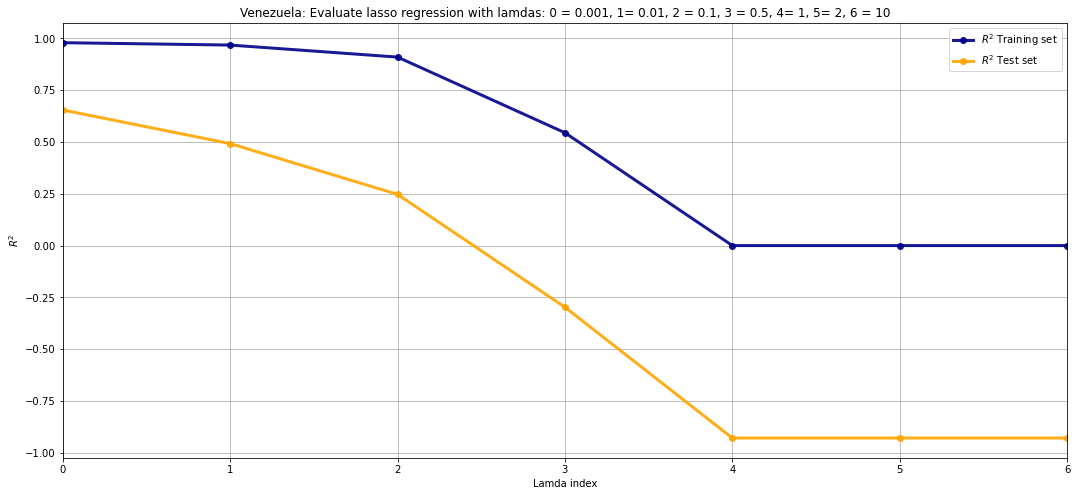

In [413]:
# Plotting
plt.figure(figsize=(18, 8))
plt.plot(train_r_squared, 'bo-', label=r'$R^2$ Training set', color="darkblue", alpha=0.9, linewidth=3)
plt.plot(test_r_squared, 'bo-', label=r'$R^2$ Test set', color="orange", alpha=0.9, linewidth=3)
plt.xlabel('Lamda index'); plt.ylabel(r'$R^2$')
plt.xlim(0, 6)
plt.title(r'Venezuela: Evaluate lasso regression with lamdas: 0 = 0.001, 1= 0.01, 2 = 0.1, 3 = 0.5, 4= 1, 5= 2, 6 = 10')
plt.legend(loc='best')
plt.grid()

In [414]:
# For Saudi Arabia
# Apply lasso with different lambdas and get r2 score for all models
lambdas = (0.001, 0.01, 0.1, 0.5, 1, 2, 10)
l_num1 = 7
pred_num1 = x1.shape[1]

# prepare data for enumerate
coeff_a1 = np.zeros((l_num1, pred_num1))
train_r_squared1 = np.zeros(l_num1)
test_r_squared1 = np.zeros(l_num1)

In [415]:
# For Saudi Arabia Data
# enumerate through lambdas with index and i
for ind1, i1 in enumerate(lambdas):    
    reg1 = Lasso(alpha = i1)
    reg1.fit(x1_train, y1_train)

    coeff_a1[ind1,:] = reg1.coef_
    train_r_squared1[ind1] = reg1.score(x1_train, y1_train)
    test_r_squared1[ind1] = reg1.score(x1_test, y1_test)

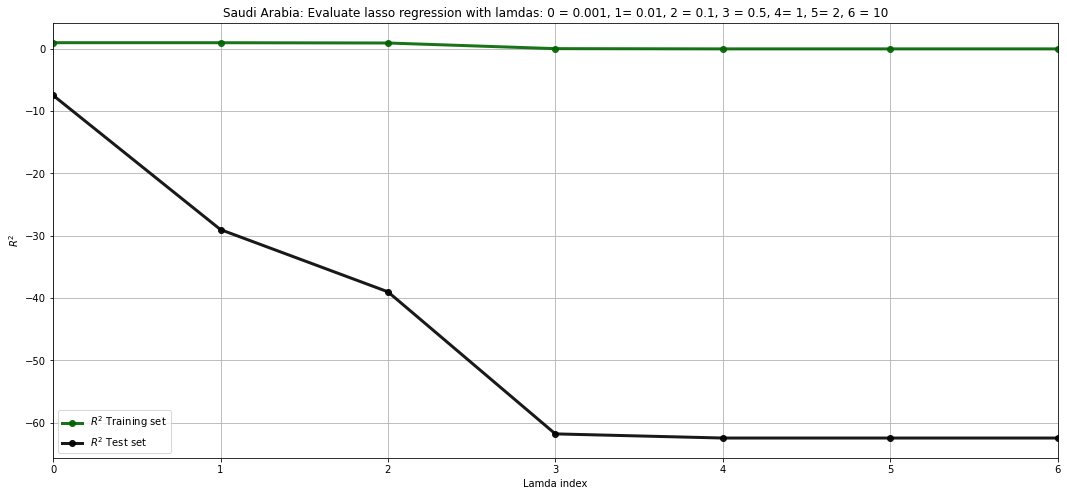

In [419]:
# Plotting
plt.figure(figsize=(18, 8))
plt.plot(train_r_squared1, 'bo-', label=r'$R^2$ Training set', color="darkgreen", alpha=0.9, linewidth=3)
plt.plot(test_r_squared1, 'bo-', label=r'$R^2$ Test set', color="black", alpha=0.9, linewidth=3)
plt.xlabel('Lamda index'); plt.ylabel(r'$R^2$')
plt.xlim(0, 6)
plt.title(r'Saudi Arabia: Evaluate lasso regression with lamdas: 0 = 0.001, 1= 0.01, 2 = 0.1, 3 = 0.5, 4= 1, 5= 2, 6 = 10')
plt.legend(loc='best')
plt.grid()

In [420]:
# For Canada
# Apply lasso with different lambdas and get r2 score for all models
lambdas = (0.001, 0.01, 0.1, 0.5, 1, 2, 10)
l_num2 = 7
pred_num2 = x2.shape[1]

# prepare data for enumerate
coeff_a2 = np.zeros((l_num2, pred_num2))
train_r_squared2 = np.zeros(l_num2)
test_r_squared2 = np.zeros(l_num2)

In [421]:
# For Canada Data
# enumerate through lambdas with index and i
for ind2, i2 in enumerate(lambdas):    
    reg2 = Lasso(alpha = i2)
    reg2.fit(x2_train, y2_train)

    coeff_a2[ind2,:] = reg2.coef_
    train_r_squared2[ind2] = reg2.score(x2_train, y2_train)
    test_r_squared2[ind2] = reg2.score(x2_test, y2_test)

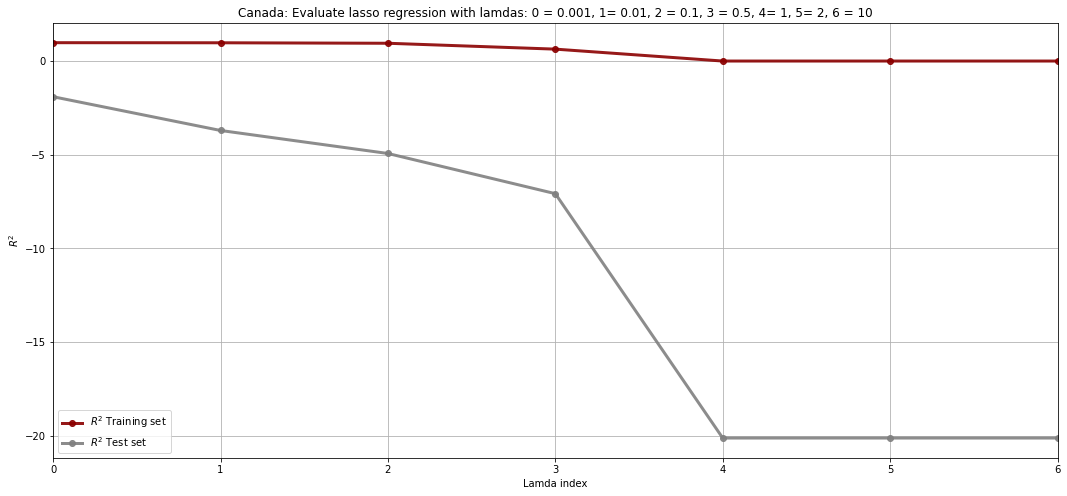

In [422]:
# Plotting
plt.figure(figsize=(18, 8))
plt.plot(train_r_squared2, 'bo-', label=r'$R^2$ Training set', color="darkred", alpha=0.9, linewidth=3)
plt.plot(test_r_squared2, 'bo-', label=r'$R^2$ Test set', color="gray", alpha=0.9, linewidth=3)
plt.xlabel('Lamda index'); plt.ylabel(r'$R^2$')
plt.xlim(0, 6)
plt.title(r'Canada: Evaluate lasso regression with lamdas: 0 = 0.001, 1= 0.01, 2 = 0.1, 3 = 0.5, 4= 1, 5= 2, 6 = 10')
plt.legend(loc='best')
plt.grid()

### 2 Coal

In [423]:
# Load data
path2 = r'C:\Users\yuvem\country_coal_production_melt.xlsx'
xls2 = pd.ExcelFile(path2)
ds2 = pd.read_excel(xls2)
ds2

,Country,Year,Exajoules
0,Canada,1981,0.969542
1,Mexico,1981,0.071145
2,US,1981,18.419096
3,NaN,1981,NaN
4,Brazil,1981,0.121479
...,...,...,...
1875,South Korea,2020,0.020180
1876,Thailand,2020,0.137418
1877,Vietnam,2020,1.139876
1878,Other Asia Pacific,2020,1.371180


In [435]:
# We're going to also read the file with the top 50 countries for most coal reserves
path3 = r'C:\Users\yuvem\top_50_coal_reserves_.xlsx'
xls3 = pd.ExcelFile(path3)
ds3 = pd.read_excel(xls3)
ds3

,Country,Anthracite and bituminous,Sub-bituminous,Total,Share of Total,R/P ratio
0,US,218938.0,30003.0,248941.0,0.231765,513.586566
1,Russian Federation,71719.0,90447.0,162166.0,0.150977,407.145368
2,Australia,73719.0,76508.0,150227.0,0.139862,315.126728
3,China,135069.0,8128.0,143197.0,0.133317,36.698360
4,Total Europe,59084.0,78156.0,137240.0,0.127771,299.079653
5,India,105979.0,5073.0,111052.0,0.103390,146.798283
6,Germany,0.0,35900.0,35900.0,0.033423,334.264432
7,Indonesia,23141.0,11728.0,34869.0,0.032463,61.986027
8,Ukraine,32039.0,2336.0,34375.0,0.032003,1428.664025
9,Poland,22530.0,5865.0,28395.0,0.026436,281.983781


**Data Cleaning**

In [425]:
# Check total NaN values
ds2.isna().sum()

Country      280
Year           0
Exajoules    362
dtype: int64

In [428]:
# Drop NaN values
ds2.dropna()
# Eliminate NaN from 'Country' column
ds2_clean = ds2[ds2["Country"].notna()]
# Replace missing values in 'Exajoules' with mean
ds2_clean["Exajoules"] = ds2_clean["Exajoules"].fillna(ds2_clean.Exajoules.mean())

In [429]:
ds2.dtypes

Country       object
Year           int64
Exajoules    float64
dtype: object

In [430]:
ds2.Country.unique()

array(['Canada', 'Mexico', 'US', nan, 'Brazil', 'Colombia', 'Venezuela',
       'Other S. & Cent. America', 'Bulgaria', 'Czech Republic',
       'Germany', 'Greece', 'Hungary', 'Poland', 'Romania', 'Serbia',
       'Spain', 'Turkey', 'Ukraine', 'United Kingdom', 'Other Europe',
       'Kazakhstan', 'Russian Federation', 'USSR', 'Uzbekistan',
       'Other CIS', 'South Africa', 'Zimbabwe', 'Other Africa',
       'Australia', 'China', 'India', 'Indonesia', 'Japan', 'Mongolia',
       'New Zealand', 'Pakistan', 'South Korea', 'Thailand', 'Vietnam',
       'Other Asia Pacific'], dtype=object)

In [431]:
# Check again
ds2_clean.isna().sum()

Country      0
Year         0
Exajoules    0
dtype: int64

In [432]:
# Convert Year to datetime
ds2_clean['Year'] = pd.to_datetime(ds2_clean.Year, format='%Y')

Recall that from our EDA, our top countries for coal production are China and U.S., with Russian Federation coming in third. We'll focus on those three countries.

### 4.a U.S. 

In [436]:
# Find index for U.S.
us_i = ds2_clean[((ds2_clean.Country == 'US'))].index
us_i

Int64Index([   2,   49,   96,  143,  190,  237,  284,  331,  378,  425,  472,
             519,  566,  613,  660,  707,  754,  801,  848,  895,  942,  989,
            1036, 1083, 1130, 1177, 1224, 1271, 1318, 1365, 1412, 1459, 1506,
            1553, 1600, 1647, 1694, 1741, 1788, 1835],
           dtype='int64')

In [437]:
# Create separate df for without US
no_us = ds2_clean.drop(us_i)
# Transform
no_us = no_us.set_index('Year').T
no_us_subset = no_us.drop('Country')

# Separate df for only U.S.
us = ds2_clean[((ds2_clean.Country == 'US'))]
# Transform
us = us.set_index('Year').T
us_subset = us.drop('Country')

In [438]:
# Combine the two datasets
coal_ds = no_us_subset.append(us_subset, ignore_index=True)
# Transform
coal_transform = coal_ds.T
# Remove duplicates 
coal_transform_ds = coal_transform[~coal_transform.index.duplicated(keep='first')]

In [439]:
coal_transform_ds

,0,1
Year,,
1981-01-01,0.969542,18.419096
1982-01-01,1.028279,18.681699
1983-01-01,1.066011,17.286391
1984-01-01,1.3964,19.764631
1985-01-01,1.487132,19.369673
1986-01-01,1.382118,19.554397
1987-01-01,1.393936,20.18749
1988-01-01,1.614195,20.785399
1989-01-01,1.7184,21.409372


### 4.b China

In [440]:
# Find index for China
china_i = ds2_clean[((ds2_clean.Country == 'China'))].index
china_i

Int64Index([  35,   82,  129,  176,  223,  270,  317,  364,  411,  458,  505,
             552,  599,  646,  693,  740,  787,  834,  881,  928,  975, 1022,
            1069, 1116, 1163, 1210, 1257, 1304, 1351, 1398, 1445, 1492, 1539,
            1586, 1633, 1680, 1727, 1774, 1821, 1868],
           dtype='int64')

In [441]:
# Create separate df for without China
no_china = ds2_clean.drop(china_i)
# Transform
no_china = no_china.set_index('Year').T
no_china_subset = no_china.drop('Country')

# Separate df for only China
china = ds2_clean[((ds2_clean.Country == 'China'))]
# Transform
china = china.set_index('Year').T
china_subset = china.drop('Country')

In [442]:
# Combine the two datasets
coal_ds2 = no_china_subset.append(china_subset, ignore_index=True)
# Transform
coal_transform2 = coal_ds2.T
# Remove duplicates 
coal_transform_ds2 = coal_transform2[~coal_transform2.index.duplicated(keep='first')]

In [443]:
coal_transform_ds2

,0,1
Year,,
1981-01-01,0.969542,13.012574
1982-01-01,1.028279,13.948324
1983-01-01,1.066011,14.957343
1984-01-01,1.3964,16.521113
1985-01-01,1.487132,18.260728
1986-01-01,1.382118,18.714996
1987-01-01,1.393936,19.428845
1988-01-01,1.614195,20.513227
1989-01-01,1.7184,22.068623


### 4.c Russian Federation

In [444]:
# Find index for China
rus_i = ds2_clean[((ds2_clean.Country == 'Russian Federation'))].index
rus_i

Int64Index([  24,   71,  118,  165,  212,  259,  306,  353,  400,  447,  494,
             541,  588,  635,  682,  729,  776,  823,  870,  917,  964, 1011,
            1058, 1105, 1152, 1199, 1246, 1293, 1340, 1387, 1434, 1481, 1528,
            1575, 1622, 1669, 1716, 1763, 1810, 1857],
           dtype='int64')

In [446]:
# Create separate df for without Russian Federation
no_rus = ds2_clean.drop(rus_i)
# Transform
no_rus = no_rus.set_index('Year').T
no_rus_subset = no_rus.drop('Country')

# Separate df for only Russian Federation
rus = ds2_clean[((ds2_clean.Country == 'Russian Federation'))]
# Transform
rus = rus.set_index('Year').T
rus_subset = rus.drop('Country')

In [447]:
# Combine the two datasets
coal_ds3 = no_rus_subset.append(rus_subset, ignore_index=True)
# Transform
coal_transform3 = coal_ds3.T
# Remove duplicates 
coal_transform_ds3 = coal_transform3[~coal_transform3.index.duplicated(keep='first')]

In [448]:
coal_transform_ds3

,0,1
Year,,
1981-01-01,0.969542,3.093079
1982-01-01,1.028279,3.093079
1983-01-01,1.066011,3.093079
1984-01-01,1.3964,3.093079
1985-01-01,1.487132,7.779312
1986-01-01,1.382118,8.045916
1987-01-01,1.393936,8.111131
1988-01-01,1.614195,8.37178
1989-01-01,1.7184,8.053129


**Causal Impact**

### 5.a U.S.

In [449]:
# Create pre and post periods
pre_period2 = ['1981-01-01','2013-01-01'] 
post_period2 = ['2014-01-01','2020-01-01']

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    1.26               8.83
Prediction (s.d.)         1.03 (0.07)        7.21 (0.5)
95% CI                    [0.89, 1.17]       [6.25, 8.21]

Absolute effect (s.d.)    0.23 (0.07)        1.62 (0.5)
95% CI                    [0.09, 0.37]       [0.62, 2.58]

Relative effect (s.d.)    22.48% (6.91%)     22.48% (6.91%)
95% CI                    [8.64%, 35.73%]    [8.64%, 35.73%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 99.9%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 1.26. By contrast, in the absence of an
intervention, we would have expected an average response of 1.03.
The 95% interval of this counterfactual prediction is [0.89, 1.17].
Subtracting this prediction from the observed response yield

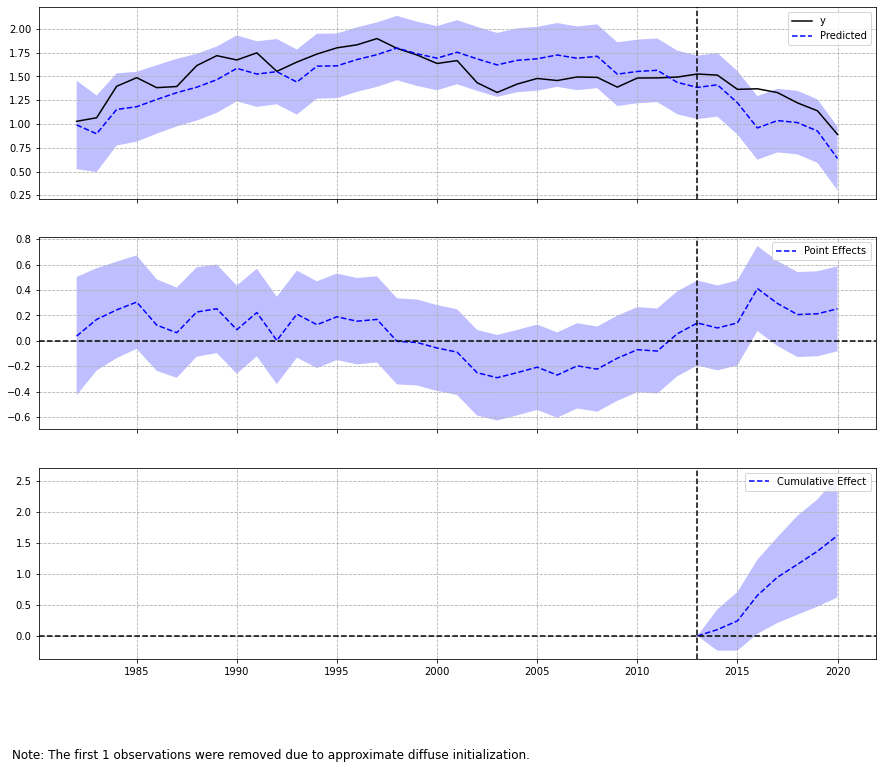

In [450]:
ci4 = CausalImpact(coal_transform_ds.astype(float), pre_period2, post_period2)
print(ci4.summary())
print(ci4.summary(output='report'))
ci4.plot()

### 5.b China

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    1.26               8.83
Prediction (s.d.)         1.53 (0.1)         10.72 (0.67)
95% CI                    [1.34, 1.72]       [9.37, 12.02]

Absolute effect (s.d.)    -0.27 (0.1)        -1.89 (0.67)
95% CI                    [-0.46, -0.08]     [-3.19, -0.54]

Relative effect (s.d.)    -17.6% (6.3%)      -17.6% (6.3%)
95% CI                    [-29.74%, -5.05%]  [-29.74%, -5.05%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 99.9%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 1.26. By contrast, in the absence of an
intervention, we would have expected an average response of 1.53.
The 95% interval of this counterfactual prediction is [1.34, 1.72].
Subtracting this prediction from the observed respon

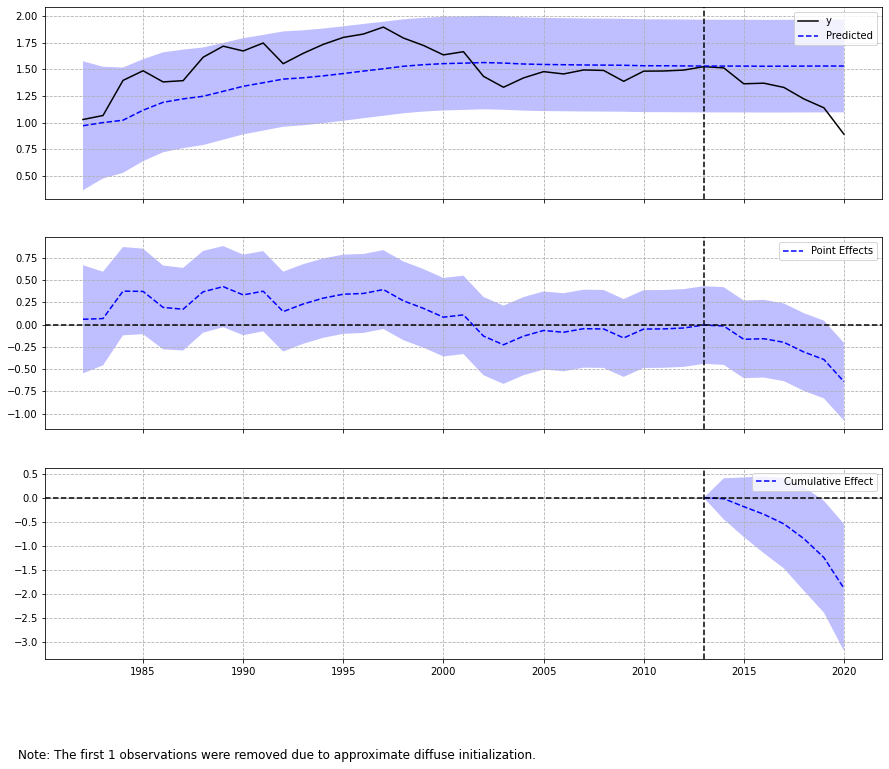

In [451]:
ci5 = CausalImpact(coal_transform_ds2.astype(float), pre_period2, post_period2)
print(ci5.summary())
print(ci5.summary(output='report'))
ci5.plot()

### 5.c Russian Federation

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    1.26               8.83
Prediction (s.d.)         1.65 (0.09)        11.53 (0.6)
95% CI                    [1.49, 1.82]       [10.41, 12.76]

Absolute effect (s.d.)    -0.39 (0.09)       -2.7 (0.6)
95% CI                    [-0.56, -0.23]     [-3.93, -1.58]

Relative effect (s.d.)    -23.44% (5.18%)    -23.44% (5.18%)
95% CI                    [-34.05%, -13.73%] [-34.05%, -13.73%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 1.26. By contrast, in the absence of an
intervention, we would have expected an average response of 1.65.
The 95% interval of this counterfactual prediction is [1.49, 1.82].
Subtracting this prediction from the observed resp

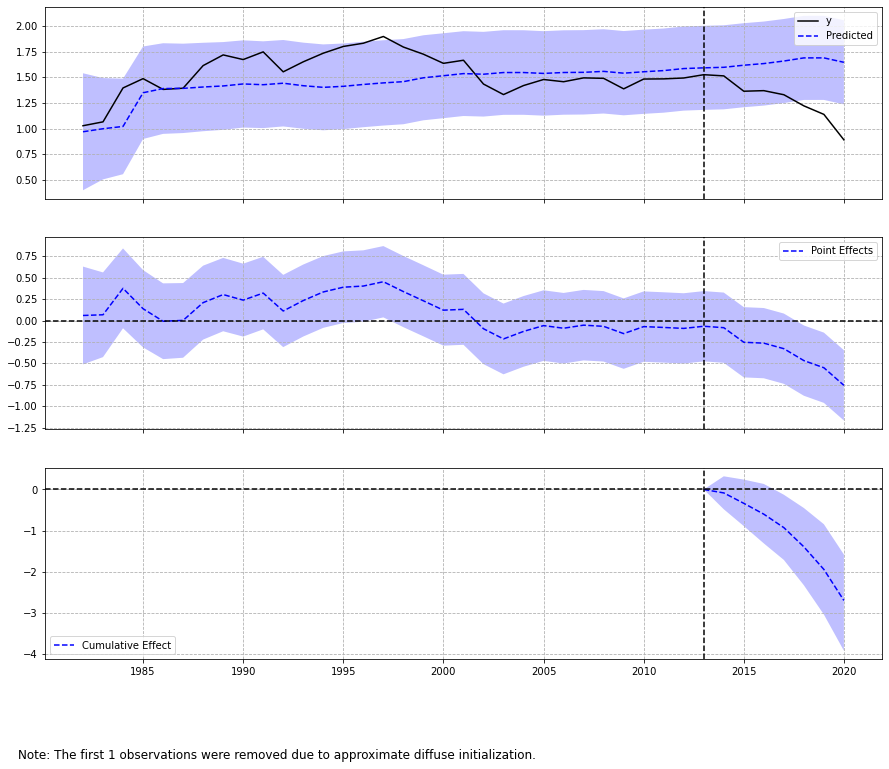

In [452]:
ci6 = CausalImpact(coal_transform_ds3.astype(float), pre_period2, post_period2)
print(ci6.summary())
print(ci6.summary(output='report'))
ci6.plot()